# Prototype Notebook Edits

This notebook is a prototype demo with professor's reccomendations for better XAI - explainable AI.

## Setup and Imports

In [1]:
# Cloud venv setup. Check/test environment
import sys
print(sys.executable)

import os
print(os.environ["PATH"])

/lambda/nfs/rc-dds/.pixi/envs/default/bin/python
/home/ubuntu/.local/bin:/home/ubuntu/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin


In [ ]:
#!sudo ln -s /home/ubuntu/.pixi/bin/pixi /usr/local/bin/pixi

In [ ]:
#!pixi

In [21]:
#!echo $PATH

/home/ubuntu/.local/bin:/home/ubuntu/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin


In [2]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer

2025-07-15 03:50:07.213207: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Set random seeds for reproducibility

In [3]:
os.environ["TF_DETERMINISTIC_OPS"] = "1"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## Load and preprocess dataset
Loading the dataset using Hugging Face, then tokenize the LaTeX formulas using a GPT-2 tokenizer.

In [7]:
# Check Jupyter environment
#!pwd

/lambda/nfs/rc-dds


In [47]:
#!pwd

/lambda/nfs/rc-dds


In [4]:
import os
print(os.getcwd())

/lambda/nfs/rc-dds


In [5]:
!pixi run python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 75.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [6]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [7]:
# Check toolchain I built and import the module
import sys

# Import custom data loader
from dataloadercore import load_inkml_pipeline

# --------------------------------------------
# Load InkML dataset pipeline
# Returns: Hugging Face DatasetDict + TF datasets dict
dataset_dir = "/lambda/nfs/rc-dds/data/mathwriting-2024/train"
dataset_dict, tf_datasets = load_inkml_pipeline(dataset_dir, split_name="train")

train: 229864 samples


Map:   0%|          | 0/229864 [00:00<?, ? examples/s]

Final dataset_dict keys: ['train']


In [8]:
# Check available splits
available_splits = list(tf_datasets.keys())
print("Available splits in TF datasets:", available_splits)

if "train" not in tf_datasets:
    print("No 'train' split found. Please check your splits or dataset preparation.")
    print("Expected columns: ['image', 'latex', 'sample_id', 'split_tag', 'data_type', 'latex_ids']")
else:
    print("'Train' split is available. Proceeding to EDA before compiling and training.")

Available splits in TF datasets: ['train']
'Train' split is available. Proceeding to EDA before compiling and training.


**Note:** We first check and confirm the dataset splits, then perform EDA on raw trace data and LaTeX labels before compiling and training any model. This allows us to understand the data distribution and structure upfront."

## Characterization and Visualization of Handwritten Stroke and Trace Data
Analyzing how handwriting can be visualized with computer vision

In [10]:
# Lets take a sample from the training data and also see
with open("/lambda/nfs/rc-dds/data/mathwriting-2024/train/c5d2c2f96689546a.inkml", "r") as f:
    for _ in range(15):
        print(f.readline().strip())

<ink xmlns="http://www.w3.org/2003/InkML">
<annotation type="label">k(\omega)=n(\omega)\omega/c</annotation>
<annotation type="splitTagOriginal">train</annotation>
<annotation type="inkCreationMethod">human</annotation>
<annotation type="sampleId">c5d2c2f96689546a</annotation>
<annotation type="normalizedLabel">k(\omega)=n(\omega)\omega/c</annotation>
<traceFormat>
<channel name="X" type="decimal" />
<channel name="Y" type="decimal" />
<channel name="T" type="decimal" units="ms" />
</traceFormat>
<trace id="0">55.00 46.00 0.0,55.00 49.27 54.0,55.00 54.00 78.0,55.00 57.22 87.0,55.00 61.00 98.0,56.00 66.00 128.0,57.00 72.00 138.0,57.00 77.00 148.0,56.21 80.14 155.0,56.00 85.00 168.0,55.00 90.00 187.0,56.95 97.84 207.0,56.00 104.00 217.0,55.00 108.00 227.0,54.61 111.78 241.0,54.00 116.00 257.0,55.00 121.00 286.0,53.00 126.00 306.0,53.00 132.00 316.0,53.00 137.00 335.0,53.00 142.00 365.0,53.00 145.34 391.0,54.40 148.81 423.0,54.00 150.69 460.0</trace>
<trace id="1">59.00 123.00 857.0,61.00

**Note:** Note the stroke and trace data above. This holdx promising for research in STEM fields such as medicine, robotics, civil engineering/construction, and more.

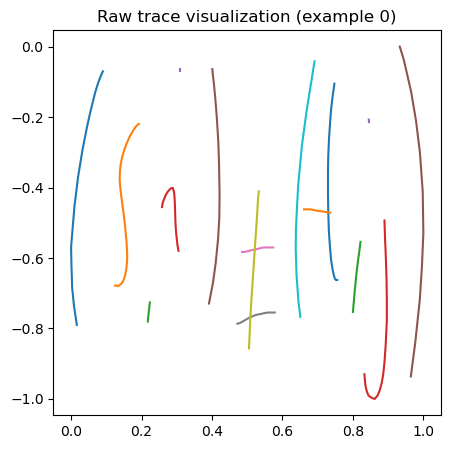

In [11]:
# Pick a sample example from Hugging Face dataset (not TensorFlow dataset yet!)
example = dataset_dict["train"][2]
raw_traces = example["traces"]

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5, 5))
for stroke in raw_traces:
    stroke = np.array(stroke)
    if stroke.shape[1] >= 2:
        plt.plot(stroke[:, 0], -stroke[:, 1])  # Flip Y axis if needed to match image
plt.title("Raw trace visualization (example 0)")
plt.axis("equal")
plt.show()

**Note:** The colored lines in the visualization are part of the Matplotlib rendering for better stroke differentiation. They do not represent different data classes. We can use black-only plots for a paper-style or simplified view if desired.

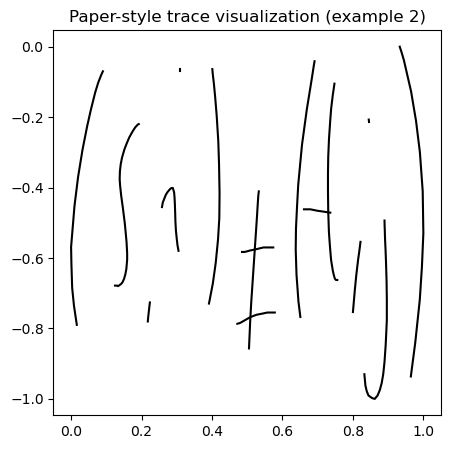

In [12]:
# Paper-style look generated
plt.figure(figsize=(5, 5))
for stroke in raw_traces:
    stroke = np.array(stroke)
    if stroke.shape[1] >= 2:
        plt.plot(stroke[:, 0], -stroke[:, 1], color="black")  # Force black lines
plt.title("Paper-style trace visualization (example 2)")
plt.axis("equal")
plt.show()

In [13]:
print("Normalized LaTeX label:", example["normalized_label"])
print("Token IDs:", example["latex_ids"])

Normalized LaTeX label: (s,i)\ne(t,j)
Token IDs: [7, 82, 11, 72, 19415, 710, 7, 83, 11, 73, 8, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]


In [14]:
# ---------------------------------------------
# Check number of samples per split
# ---------------------------------------------
print("\nDataset sample counts per split:")
for split_name in dataset_dict:
    print(f"{split_name}: {len(dataset_dict[split_name])} samples")

# ---------------------------------------------
# Print keys of first example
# ---------------------------------------------
example = dataset_dict["train"][0]
print("\nFirst example keys:", list(example.keys()))

# Print LaTeX label and token ids
print("\nNormalized LaTeX label:", example["normalized_label"])
print("Token IDs:", example["latex_ids"])

# Print shape of padded traces
if "padded_traces" in example:
    print("Shape of padded_traces:", np.array(example["padded_traces"]).shape)


Dataset sample counts per split:
train: 229864 samples

First example keys: ['traces', 'latex_ids', 'normalized_label', 'file_path', 'padded_traces']

Normalized LaTeX label: \dot{y}=\frac{dy}{dt}
Token IDs: [59, 26518, 90, 88, 92, 28, 59, 31944, 90, 9892, 18477, 28664, 92, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]
Shape of padded_traces: (300, 3)


## Tokenization
According to Google: Tokenization is, "the process of converting raw text into a sequence of numerical tokens that a machine learning model can understand."
- This is an industry standard, but--tokenization is not the only method or technique to build in the ML/DL space.

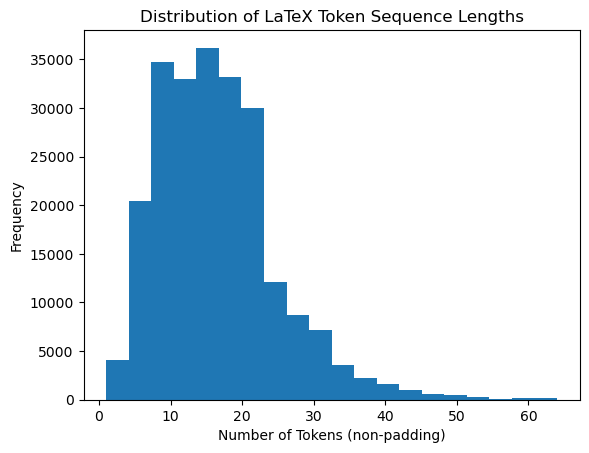

In [15]:
# Test pass on tokenization
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

lengths = [len([id for id in ex["latex_ids"] if id != tokenizer.pad_token_id]) for ex in dataset_dict["train"]]
plt.hist(lengths, bins=20)
plt.title("Distribution of LaTeX Token Sequence Lengths")
plt.xlabel("Number of Tokens (non-padding)")
plt.ylabel("Frequency")
plt.show()

In [52]:
# Check train/test/validate data loaded in memory
print(dataset_dict)
print(tf_datasets.keys())

DatasetDict({
    train: Dataset({
        features: ['traces', 'latex_ids', 'normalized_label', 'file_path', 'padded_traces'],
        num_rows: 229864
    })
})
dict_keys(['train'])


In [53]:
tf_train = tf_datasets["train"]

## Image Augmentation
We apply common augmentation techniques to improve model generalization.

In [21]:
# Run some image augmentation tests
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomContrast(0.1),
    ],
    name="data_augmentation"
)

## How a Machine 'Sees' -- Computer Vision

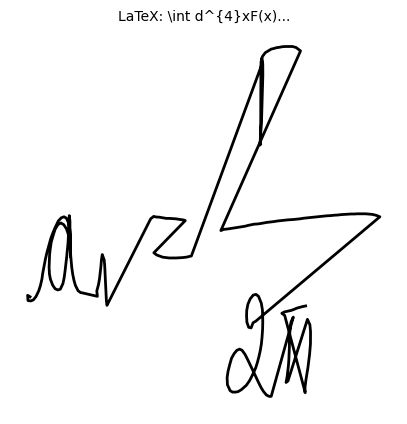

Full LaTeX string: \int d^{4}xF(x)


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

def render_trace(trace, ax, color="black"):
    trace = np.array(trace)
    ax.plot(trace[:, 0], -trace[:, 1], color=color, linewidth=2)
    ax.axis("off")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

for batch in tf_train.take(1):
    traces_batch = batch["padded_traces"].numpy()
    latex_ids = batch["latex_ids"].numpy()
    break

sample_trace = traces_batch[3]
decoded_latex = tokenizer.decode(latex_ids[0], skip_special_tokens=True)

# Plot
fig, ax = plt.subplots(figsize=(5, 5))
render_trace(sample_trace, ax)
plt.title(f"LaTeX: {decoded_latex[:20]}...", fontsize=10)  
plt.show()

print("Full LaTeX string:", decoded_latex)

## Model Normalization Features 

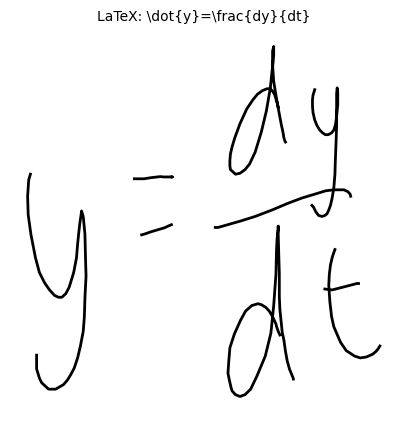

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def plot_traces_separate_strokes(traces_list, ax, color="black"):
    """
    traces_list: list of strokes, each stroke is an array of shape (n_points, 3)
    """
    for stroke in traces_list:
        stroke = np.array(stroke)
        ax.plot(stroke[:, 0], -stroke[:, 1], color=color, linewidth=2)
    ax.axis("off")

# From your dataloader, get raw traces instead of padded
for batch in tf_train.take(1):
    # This assumes you still have original "traces" column in dataset_dict
    sample_idx = 0
    sample_file_path = dataset_dict["train"][sample_idx]["file_path"]
    sample_label = dataset_dict["train"][sample_idx]["normalized_label"]
    sample_traces = dataset_dict["train"][sample_idx]["traces"]
    break

fig, ax = plt.subplots(figsize=(5, 5))
plot_traces_separate_strokes(sample_traces, ax)
plt.title(f"LaTeX: {sample_label}", fontsize=10)
plt.show()

## Load Test/Validation Set

In [17]:
from dataloadercore import load_inkml_pipeline

# Set file paths
val_dir = "/lambda/nfs/rc-dds/data/mathwriting-2024/valid"
test_dir = "/lambda/nfs/rc-dds/data/mathwriting-2024/test"


# Load validation dataset
val_dataset_dict, val_tf_datasets = load_inkml_pipeline(val_dir, split_name="valid")

# Load test dataset
test_dataset_dict, test_tf_datasets = load_inkml_pipeline(test_dir, split_name="test")

# Assign TensorFlow datasets for val and test
tf_val = val_tf_datasets["valid"]    
tf_test = test_tf_datasets["test"]

valid: 15674 samples


Map:   0%|          | 0/15674 [00:00<?, ? examples/s]

Final dataset_dict keys: ['valid']
test: 7644 samples


Map:   0%|          | 0/7644 [00:00<?, ? examples/s]

Final dataset_dict keys: ['test']


In [20]:
# Logging configs
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Confirm keys 
print("Val keys:", val_tf_datasets.keys())
print("Test keys:", test_tf_datasets.keys())


# Check one batch from validation set
for batch in tf_val.take(1):
    print("Val batch keys:", batch.keys())
    print("Val padded_traces shape:", batch["padded_traces"].shape)
    print("Val latex_ids shape:", batch["latex_ids"].shape)

# Check one batch from test set
for batch in tf_test.take(1):
    print("Test batch keys:", batch.keys())
    print("Test padded_traces shape:", batch["padded_traces"].shape)
    print("Test latex_ids shape:", batch["latex_ids"].shape)

Val keys: dict_keys(['valid'])
Test keys: dict_keys(['test'])
Val batch keys: dict_keys(['latex_ids', 'padded_traces'])
Val padded_traces shape: (32, 300, 3)
Val latex_ids shape: (32, 64)
Test batch keys: dict_keys(['latex_ids', 'padded_traces'])
Test padded_traces shape: (32, 300, 3)
Test latex_ids shape: (32, 64)


2025-07-15 04:28:46.326796: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Lambda AI Cloud
Check and test cloud compute GPU's

In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Is built with CUDA:", tf.test.is_built_with_cuda())
print("Physical GPUs:", tf.config.list_physical_devices('GPU'))

2025-07-15 06:04:10.213578: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.18.0
Is built with CUDA: False
Physical GPUs: []


In [2]:
#!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2025 NVIDIA Corporation
Built on Fri_Feb_21_20:23:50_PST_2025
Cuda compilation tools, release 12.8, V12.8.93
Build cuda_12.8.r12.8/compiler.35583870_0


In [45]:
import tensorflow as tf
print(tf.__version__)

2.18.0


## Define Model (Prototype #2)
This is just a rough draft prototype with two branches: one for images and one for LaTeX text tokens.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from dataloadercore import load_inkml_pipeline
from transformers import AutoTokenizer
from tensorflow.keras import mixed_precision

# Mixed precision
mixed_precision.set_global_policy("mixed_float16")

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
vocab_size = tokenizer.vocab_size

# Split function
def split_latex_ids(example):
    ids = example["latex_ids"]
    example["decoder_input_ids"] = [tokenizer.eos_token_id] + ids[:-1]
    example["decoder_target_ids"] = ids # target variable
    return example

dataset_dict["train"] = dataset_dict["train"].map(split_latex_ids)

# Check sequence lengths (optional)
lengths = [len(ids) for ids in dataset_dict["train"]["latex_ids"]]
print(f"Mean length: {sum(lengths) / len(lengths):.2f}, Max length: {max(lengths)}")

# TF dataset
batch_size = 64  

tf_train = (
    dataset_dict["train"]
    .to_tf_dataset(
        columns=["padded_traces", "decoder_input_ids"],
        label_cols=["decoder_target_ids"],
        shuffle=True,
        batch_size=batch_size,
    )
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

# Encoder
encoder_inputs = keras.Input(shape=(300, 3), name="padded_traces")
x = layers.Masking()(encoder_inputs)
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
encoder_states = layers.Bidirectional(layers.LSTM(256, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_states(x)
state_h = layers.Concatenate()([forward_h, backward_h])
state_c = layers.Concatenate()([forward_c, backward_c])

# Decoder
decoder_inputs = keras.Input(shape=(None,), name="decoder_input_ids", dtype="int32")
embedding_dim = 256

x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)(decoder_inputs)
x = layers.LSTM(512, return_sequences=True)(x, initial_state=[state_h, state_c])
decoder_outputs = layers.TimeDistributed(layers.Dense(vocab_size))(x)

# Model
model = keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs, name="version-cv")

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

model.summary()
model.fit(tf_train, epochs=10)

## Model Summary

In [ ]:
model.summary()
keras.utils.plot_model(model, show_shapes=True)
model.save("version-cv.h5")
model.save("version-cv.keras")

## Training and Validation Metrics
Visualize accuracy and loss curves.

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Val Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

plt.show()

In [ ]:
# Prototype for base model. Still need to run, test, validate. not completed.

**Note:** The InkML pipeline is designed to handle trace annotations by parsing each <trace> element, which captures pen strokes as (X, Y, T) sequences. These traces are then rasterized into image representations and optionally used to extract dynamic features (e.g., stroke velocity, acceleration). The dataloader stores these images in the image column, and the corresponding LaTeX is tokenized into latex_ids.

The InkML `traceFormat` and `trace` elements are used to create raster images representing handwritten formulas. These images are stored in the image column of our dataset. We do not keep raw traces as separate columns, because they are transformed and integrated into the image representation pipeline. However, if needed, we can also retain raw trace data for further analysis or visualization.